In [ ]:
# krag 0.0.17 버전을 설치 (현재 버전을 사용할 경우 업데이트 차이에 따른 에러 발생)
!pip install krag==0.0.17

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

# 필요한 라이브러리

In [2]:
import time
import psutil
import os
import re
import shutil
import pandas as pd
import numpy as np
from typing import List, Dict, Any
from langchain.schema import Document
from langchain.document_loaders import TextLoader
from langchain.vectorstores import Chroma, FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from krag.document import KragDocument
from krag.evaluators import OfflineRetrievalEvaluators, RougeOfflineRetrievalEvaluators

import chromadb
from chromadb.config import Settings
import weaviate
import weaviate.classes as wvc

## 평가를 위한 유틸리티 함수

In [3]:
def get_process_memory():
    """현재 프로세스의 메모리 사용량을 반환합니다."""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss

def track_memory_usage(func):
    """함수 실행 전후의 메모리 사용량 변화를 추적하는 데코레이터입니다."""
    def wrapper(*args, **kwargs):
        memory_before = get_process_memory()
        result = func(*args, **kwargs)
        memory_after = get_process_memory()
        print(f"메모리 사용량: {(memory_after - memory_before) / 1024 / 1024:.2f} MB")
        return result
    return wrapper

# 데이터 준비 함수

In [4]:
def split_menu_items(document):
    # 메뉴 항목을 분리하기 위한 정규 표현식
    pattern = r'(\d+\.\s.*?)(?=\n\n\d+\.|$)'
    
    # 전체 텍스트에서 메뉴 항목 분리
    menu_items = re.findall(pattern, document.page_content, re.DOTALL)
    
    # 각 메뉴 항목을 Document 객체로 변환
    menu_documents = []
    for i, item in enumerate(menu_items, 1):
        # 메뉴 이름 추출
        menu_name = item.split('\n')[0].split('.', 1)[1].strip()
        
        # 새로운 Document 객체 생성
        menu_doc = Document(
            page_content=item.strip(),
            metadata={
                "source": document.metadata['source'],
                "menu_number": i,
                "menu_name": menu_name
            }
        )
        menu_documents.append(menu_doc)
    
    return menu_documents

In [5]:
@track_memory_usage
def prepare_menu_data(file_path: str) -> List[Document]:
    """
    데이터를 로드하고, Document 객체로 변환합니다.
    """
    # 텍스트 데이터를 로드
    loader = TextLoader(file_path)
    documents = loader.load()

    # 메뉴 항목 분리 실행
    menu_documents = []
    for doc in documents:
        menu_documents += split_menu_items(doc)

    return menu_documents

# 벡터 저장소 초기화 함수

In [6]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [7]:
@track_memory_usage
def init_vectorstores(documents: List[Document], embeddings):
    """Chroma, FAISS, Weaviate 벡터 저장소를 초기화합니다."""


    # Chroma 초기화
    start_time = time.time()
    chroma_client = chromadb.Client(Settings(allow_reset=True))

    # 기존 Chroma DB 디렉토리 삭제
    chroma_persist_dir = "./chroma_db_test"
    if os.path.exists(chroma_persist_dir):
        shutil.rmtree(chroma_persist_dir)


    collection_name = "db_test" 
    
    if collection_name in [d.name for d in chroma_client.list_collections()]:
        chroma_client.delete_collection(collection_name)
        
    chroma_db = Chroma.from_documents(
        documents, 
        embeddings,
        client=chroma_client,
        collection_name=collection_name,
        persist_directory=chroma_persist_dir,
    )

    chroma_time = time.time() - start_time
    print(f"Chroma 인덱싱 시간: {chroma_time:.2f} 초")


    # FAISS 초기화
    start_time = time.time()
    faiss_db = FAISS.from_documents(documents, embeddings)
    faiss_time = time.time() - start_time
    print(f"FAISS 인덱싱 시간: {faiss_time:.2f} 초")

    # Weaviate 초기화
    client = weaviate.connect_to_local()
    
    # 기존 스키마 삭제
    client.collections.delete_all()
    
    # 새로운 클래스 생성
    collection = client.collections.create(
        name="Document",
        vectorizer_config=wvc.config.Configure.Vectorizer.text2vec_transformers()
    )

    # 데이터 추가
    start_time = time.time()
    
    data_objects = [{"content": doc.page_content} for doc in documents]
    collection.data.insert_many(data_objects)

    weaviate_time = time.time() - start_time
    print(f"Weaviate 인덱싱 시간: {weaviate_time:.2f} 초")

    # client.close()

    return chroma_db, faiss_db, client  # client를 weaviate_db로 사용

In [49]:
# 데이터 파일 경로
file_path = "./data/restaurant_menu.txt"

# 데이터 준비
documents = prepare_menu_data(file_path)

print("문서 수: ", len(documents))

# 벡터 저장소 초기화
chroma_db, faiss_db, weaviate_db = init_vectorstores(documents, embeddings)

메모리 사용량: 0.86 MB
문서 수:  10
Chroma 인덱싱 시간: 0.75 초
FAISS 인덱싱 시간: 0.71 초
Weaviate 인덱싱 시간: 1.56 초
메모리 사용량: 31.22 MB


# 쿼리 실행 함수

In [9]:
def run_query(db: Any, query: str) -> List[KragDocument]:
    """주어진 데이터베이스에서 쿼리를 실행하고 결과를 반환합니다."""

    if isinstance(db, (Chroma, FAISS)):
        results = db.similarity_search(query)
        return [KragDocument(metadata={'id': i}, page_content=doc.page_content) for i, doc in enumerate(results)]
    
    elif isinstance(db, weaviate.WeaviateClient):
        collection = db.collections.get("Document")
        results = collection.query.near_text(
            query=query,
            limit=4,  # 원하는 결과 개수로 조정
            return_properties=["content"]
        )
        return [KragDocument(metadata={'id': i}, page_content=obj.properties['content']) for i, obj in enumerate(results.objects)]

In [10]:
# 테스트 데이터 로드
df_test = pd.read_csv("./data/restaurant_menu_test_data_with_context.csv")
df_test.head(2)

,menu_name,question,answer,context_docs
0,시그니처 스테이크,이 레스토랑의 대표 메뉴로 알려진 고기 요리의 가격은 얼마인가요?,"시그니처 스테이크의 가격은 ₩35,000입니다.",[Document(metadata={'menu_name': ' 시그니처 스테이크 '...
1,트러플 리조또,이탈리아 쌀요리 중 가장 비싼 메뉴는 무엇인가요?,"트러플 리조또로, 가격은 ₩22,000입니다.","[Document(metadata={'menu_name': ' 트러플 리조또 '},..."


In [11]:
# 데이터 준비
queries = df_test['question'].tolist()
actual_docs = [eval(doc) for doc in df_test['context_docs']]

# 0번째 쿼리 실행
query = queries[0]

# 쿼리 실행
results_chroma = run_query(chroma_db, query)
results_faiss = run_query(faiss_db, query)
results_weaviate = run_query(weaviate_db, query)

# 결과 비교
print("Chroma 검색 결과:")
for doc in results_chroma:
    print(doc.page_content)
    print()

print("FAISS 검색 결과:")
for doc in results_faiss:
    print(doc.page_content)
    print()

print("Weaviate 검색 결과:")
for doc in results_weaviate:
    print(doc.page_content)
    print()

Chroma 검색 결과:
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.

8. 안심 스테이크 샐러드
   • 가격: ₩26,000
   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈
   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.

2. 트러플 리조또
   • 가격: ₩22,000
   • 주요 식재료: 이탈리아산 아르보리오 쌀, 블랙 트러플, 파르미지아노 레지아노 치즈
   • 설명: 크리미한 텍스처의 리조또에 고급 블랙 트러플을 듬뿍 얹어 풍부한 향과 맛을 즐길 수 있는 메뉴입니다. 24개월 숙성된 파르미지아노 레지아노 치즈를 사용하여 깊은 맛을 더했으며, 주문 즉시 조리하여 최상의 상태로 제공됩니다.

3. 연어 타르타르
   • 가격: ₩18,000
   • 주요 식재료: 노르웨이산 생연어, 아보카도, 케이퍼, 적양파
   • 설명: 신선한 노르웨이산 생연어를 곱게 다져 아보카도, 케이퍼, 적양파와 함께 섞어 만든 타르타르입니다. 레몬 드레싱으로 상큼한 맛을 더했으며, 바삭한 브리오쉬 토스트와 함께 제공됩니다. 전채요리로 완벽한 메뉴입니다.

FAISS 검색 결과:
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로

# 벤치마크 실행 함수

In [53]:
@track_memory_usage
def run_benchmark(db: Any, queries: List[str], actual_docs: List[List[KragDocument]]):
    """
    주어진 데이터베이스에 대해 벤치마크를 실행하고 결과를 데이터프레임으로 반환합니다.
    """
    def bench():
        run_query(db, np.random.choice(queries))

    # 쿼리 실행 시간 측정
    start_time = time.time()
    for _ in range(10):  # 10번 반복하여 평균 시간 계산
        bench()
    end_time = time.time()
    avg_time = (end_time - start_time) / 10

    # 모든 쿼리에 대한 결과를 저장할 리스트
    all_results = []

    # 각 쿼리에 대해 평가 지표 계산
    for i, (query, actual) in enumerate(zip(queries, actual_docs)):
        predicted_docs = [run_query(db, query)]
        evaluator = RougeOfflineRetrievalEvaluators([actual], predicted_docs, match_method="rouge1", threshold=0.8)

        k_values = [1, 2, 3, 4]
        for k in k_values:
            result = {
                'Query': f'Query {i+1}',
                'k': k,
                'Hit Rate': evaluator.calculate_hit_rate(k=k),
                'MRR': evaluator.calculate_mrr(k=k),
            }
            all_results.append(result)

    # 결과를 데이터프레임으로 변환
    df_results = pd.DataFrame(all_results)

    # 평균 계산 및 추가 (Query 열 제외)
    avg_results = df_results.groupby('k').mean(numeric_only=True).reset_index()
    avg_results['Query'] = 'Average'
    df_results = pd.concat([df_results, avg_results]).reset_index(drop=True)

    # 성능 메트릭 추가
    performance_metrics = pd.DataFrame({
        'Metric': ['Average Query Time', 'Queries per Second'],
        'Value': [avg_time, 1 / avg_time]
    })

    return df_results, performance_metrics

In [54]:
queries = df_test['question'].tolist()
actual_docs = [eval(doc) for doc in df_test['context_docs']]

results_chroma, performance_chroma = run_benchmark(chroma_db, queries, actual_docs)

results_chroma.tail(4)

메모리 사용량: 38.72 MB


,Query,k,Hit Rate,MRR
60,Average,1,0.333333,0.333333
61,Average,2,0.533333,0.433333
62,Average,3,0.666667,0.477778
63,Average,4,0.733333,0.494444


In [55]:
performance_chroma

,Metric,Value
0,Average Query Time,0.301781
1,Queries per Second,3.313666


In [56]:
results_faiss, performance_faiss = run_benchmark(faiss_db, queries, actual_docs)

results_faiss.tail(4)

메모리 사용량: 1.50 MB


,Query,k,Hit Rate,MRR
60,Average,1,0.333333,0.333333
61,Average,2,0.533333,0.433333
62,Average,3,0.666667,0.477778
63,Average,4,0.733333,0.494444


In [57]:
performance_faiss

,Metric,Value
0,Average Query Time,0.296089
1,Queries per Second,3.377367


In [58]:
results_weaviate, performance_weaviate = run_benchmark(weaviate_db, queries, actual_docs)

results_weaviate.tail(4)

메모리 사용량: 7.59 MB


,Query,k,Hit Rate,MRR
60,Average,1,0.133333,0.133333
61,Average,2,0.200000,0.166667
62,Average,3,0.400000,0.233333
63,Average,4,0.466667,0.250000


In [59]:
performance_weaviate

,Metric,Value
0,Average Query Time,0.035653
1,Queries per Second,28.048378


In [60]:
# performance 결과를 종합

import matplotlib.pyplot as plt

performance_results = pd.concat([performance_chroma.set_index('Metric'), performance_faiss.set_index('Metric'), performance_weaviate.set_index('Metric')], axis=1)
performance_results.columns = ['Chroma', 'FAISS', 'Weaviate']

performance_results


,Chroma,FAISS,Weaviate
Metric,,,
Average Query Time,0.301781,0.296089,0.035653
Queries per Second,3.313666,3.377367,28.048378


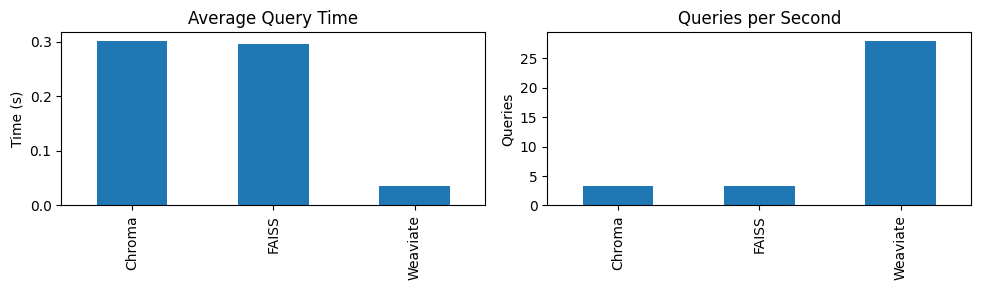

In [70]:
# 성능 메트릭 시각화
plt.subplot(1, 2, 1)
performance_results.loc['Average Query Time'].plot(kind='bar', figsize=(10, 3))
plt.title('Average Query Time')
plt.ylabel('Time (s)')

plt.subplot(1, 2, 2)
performance_results.loc['Queries per Second'].plot(kind='bar', figsize=(10, 3))
plt.title('Queries per Second')
plt.ylabel('Queries')

plt.tight_layout()
plt.show()
